# Proper GPs
Much here changed with the help of the `Flux Experimentation.ipynb` notebook. I'll try to make pretty, functional GPs here.

In [1]:
using LinearAlgebra
using Plots
using Distributions

For now we will only consider GPs with zero mean and RBF kernel.

In [2]:
zero_mean() = x -> zeros(size(x))

zero_mean (generic function with 1 method)

In [3]:
rbf(l, σ_f) = 
    (x₁, x₂) -> exp.(σ_f).^2 .* exp.(- (x₁ .- x₂').^2 ./ exp.(l).^2)

rbf (generic function with 1 method)

Define a new structure `GP` with mean, kernel, and likelihood. It might be better to have a separate likelihood object, but for now this seems handy.

In [4]:
struct GP
    μ
    k
    σ_n
end

In [5]:
gp = GP(zero_mean(), rbf([log(2)], [log(0.5)]), [log(0.5)])

GP(getfield(Main, Symbol("##3#4"))(), getfield(Main, Symbol("##5#6")){Array{Float64,1},Array{Float64,1}}([0.693147], [-0.693147]), [-0.693147])

## Prior sample

In [6]:
prior(gp, X) = MultivariateNormal(gp.μ(X), gp.k(X, X) + 1e-6I)

prior (generic function with 1 method)

In [7]:
Xs = 0:0.01:10
prior_distribution = prior(gp, Xs)

FullNormal(
dim: 1001
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [0.250001 0.249994 … 3.64991e-12 3.47199e-12; 0.249994 0.250001 … 3.83675e-12 3.64991e-12; … ; 3.64991e-12 3.83675e-12 … 0.250001 0.249994; 3.47199e-12 3.64991e-12 … 0.249994 0.250001]
)


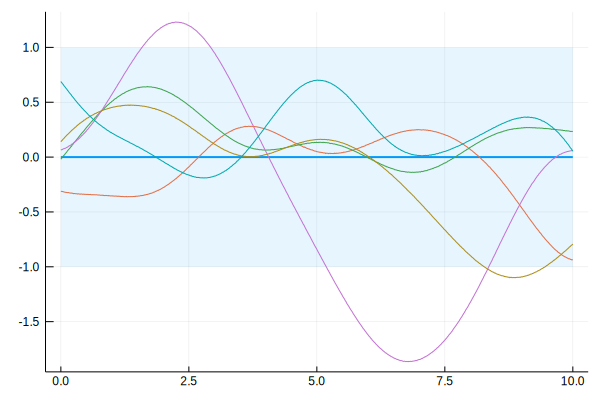

In [8]:
plot(
    Xs, prior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(prior_distribution.Σ)), 
    fillalpha=0.1, 
    leg=false,
)
plot!(Xs, rand(prior_distribution, 5))

## Posterior Sample
First generate some evidence from a single GP sample.

Then condition the GP on this evidence and plot the mean, variance, and some samples from this conditioned GP.

In [9]:
generating_gp = GP(zero_mean(), rbf([log(0.5)], [log(2)]), [log(0.05)])
n = 100
X = 1 .+ rand(n) * 8
generating_dist = prior(generating_gp, Xs)
idx = sample(1:length(Xs), n)
X = Xs[idx]
full_f = rand(generating_dist)
f = full_f[idx]
y = f .+ randn(size(f)) .* exp.(generating_gp.σ_n)

100-element Array{Float64,1}:
  0.9848577937172954  
  0.5771436116221892  
  1.3634401748279574  
  0.11891751017162941 
 -3.457289232672414   
  2.7740342913677005  
  2.4696622789998397  
  0.032868645984324145
  0.6675900828263336  
 -1.167821198739675   
 -4.07602940367199    
  2.820350442922262   
  0.19394993113146475 
  ⋮                   
 -3.484439196059764   
 -0.31691480403690103 
  3.6343948701289555  
  6.686481350625471   
  0.6874048866240462  
  2.369663783365701   
 -1.3376697372443447  
  2.782260611867989   
 -1.5813254137309813  
  3.5467915992558017  
  1.2063090836841242  
  3.4673176532625907  

In [10]:
function posterior(gp, X, y, Xs) 
    K = gp.k(X, X)
    Ks = gp.k(X, Xs)
    Kss = gp.k(Xs, Xs)

    K_inv = inv(K + exp.(gp.σ_n)[1].^2 * I + 1e-6*I)

    cov = Kss - Ks' * K_inv * Ks
    mean = Ks' * K_inv * y
    
    return MultivariateNormal(mean, Symmetric(cov + 1e-6I))
end

posterior (generic function with 1 method)

In [11]:
posterior_distribution = posterior(gp, X, y, Xs)

FullNormal(
dim: 1001
μ: [-0.599471, -0.566672, -0.533638, -0.500375, -0.466887, -0.433178, -0.399253, -0.365115, -0.330769, -0.29622  …  2.27527, 2.28944, 2.30336, 2.317, 2.33038, 2.3435, 2.35634, 2.36891, 2.3812, 2.39323]
Σ: [0.0349187 0.0346386 … 6.68345e-6 6.60005e-6; 0.0346386 0.0343671 … 6.75025e-6 6.6708e-6; … ; 6.68345e-6 6.75025e-6 … 0.0257972 0.0260351; 6.60005e-6 6.6708e-6 … 0.0260351 0.0262813]
)


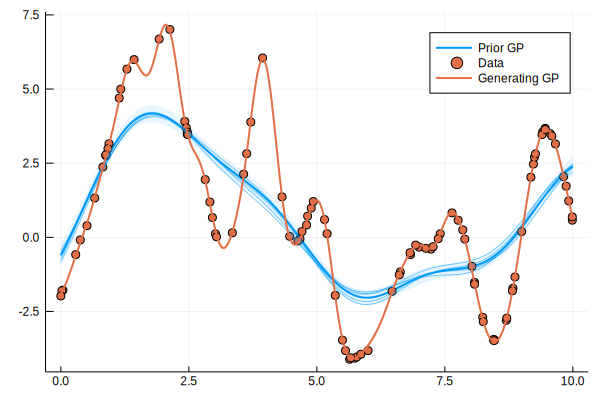

In [12]:
plot(
    Xs, posterior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(posterior_distribution.Σ)), 
    fillalpha=0.1, 
    label="Prior GP"
)
scatter!(X, y, label="Data", color=2)
plot!(Xs, rand(posterior_distribution, 5), 
    label="",
    color=1, alpha=0.5,
)

plot!(Xs, full_f, width=2, 
    ribbon=2exp.(generating_gp.σ_n), 
    fillalpha=0.1, 
    label="Generating GP",
    color=2
)

## Hyperparameter optimization
Now for the fun part: Optimize the GP hyperparameters with Flux and Zygote!

In [13]:
using Flux, Zygote

In [14]:
function mll(gp, X, y)
    data_fit = -1/2 * y' * inv(gp.k(X, X) + exp.(gp.σ_n)[1]^2 * I + 1e-6I) * y
    model_complexity = -1/2 * logdet(gp.k(X, X)+exp.(gp.σ_n)[1].^2*I + 1e-6I)
    normalization_term = -length(y)/2 * log(2π)
    @assert length(data_fit) == 1
    @assert length(model_complexity) == 1
    @assert length(normalization_term) == 1
    return data_fit[1] + model_complexity[1] + normalization_term[1]
end
mll(gp, X, y)

-659.8024127907556

In [15]:
prior(gp) = logpdf(Gamma(2, 0.05), exp.(gp.k.l)[1])
prior(gp)

-33.31538827233207

In [16]:
gp_gs, = gradient(m -> -mll(m, X, y), gp)

((μ = nothing, k = (l = [497.562], σ_f = [-242.944]), σ_n = [-914.409]),)

Naive gradient descent for now, since I don't know how to properly use Flux

In [17]:
η = 0.001
for epoch=1:100
    gp_gs, = gradient(m -> -mll(m, X, y), gp)
    Flux.Tracker.update!(gp.k.l, -η*gp_gs.k.l)
    Flux.Tracker.update!(gp.k.σ_f, -η*gp_gs.k.σ_f)
    Flux.Tracker.update!(gp.σ_n, -η*gp_gs.σ_n)
    if epoch % 100 == 0
        println(epoch, exp.(gp.k.l), exp.(gp.k.σ_f), exp.(gp.σ_n))
    end
end
println("True parameters:", exp.(generating_gp.k.l), exp.(generating_gp.k.σ_f), exp.(generating_gp.σ_n))

100[0.485026][2.66746][0.0472015]
True parameters:[0.5][2.0][0.05]


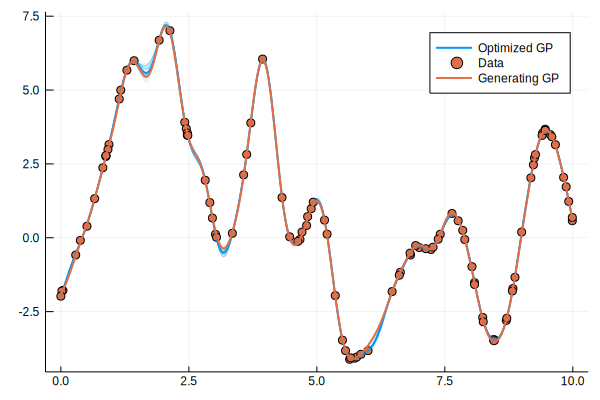

In [18]:
posterior_distribution = posterior(gp, X, y, Xs)
plot(
    Xs, posterior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(posterior_distribution.Σ)), 
    fillalpha=0.1, 
    label="Optimized GP"
)
scatter!(X, y, label="Data", color=2)
plot!(Xs, rand(posterior_distribution, 5), 
    label="",
    color=1, alpha=0.5,
)

plot!(Xs, full_f, width=2, 
    ribbon=2exp.(generating_gp.σ_n), 
    fillalpha=0.1, 
    label="Generating GP",
    color=2
)